In [1]:
import torch 
from torch import Tensor 
import numpy as np
import math
import matplotlib.pyplot as plt

## Data Generation

In [2]:
data = torch.FloatTensor(1000,2).uniform_(0,1)
distance = torch.sqrt(torch.pow(data[:, 0], 2) + torch.pow(data[:,1],2)).view(-1,1)
radius = 1 / math.sqrt(2 * math.pi)
inside = distance.clone().apply_(lambda x : 1 if x < radius else  -1)
outside = distance.clone().apply_(lambda x : 1 if x > radius else  -1)

target = torch.cat((inside, outside),1)

In [3]:
data


 0.5780  0.7871
 0.9017  0.0830
 0.1327  0.4380
       ⋮        
 0.5407  0.5187
 0.6770  0.6237
 0.1992  0.2195
[torch.FloatTensor of size 1000x2]

In [4]:
distance



 0.9765
 0.9055
 0.4577
   ⋮    
 0.7493
 0.9205
 0.2964
[torch.FloatTensor of size 1000x1]

In [5]:
radius

0.3989422804014327

In [6]:
target



   -1     1
   -1     1
   -1     1
     ⋮      
   -1     1
   -1     1
    1    -1
[torch.FloatTensor of size 1000x2]

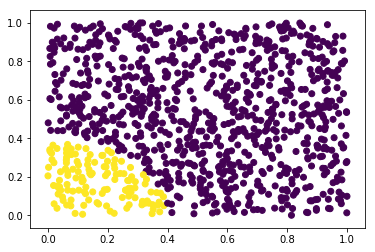

In [7]:
plt.scatter(data[:,0], data[:,1], c=inside)
plt.show()

## ReLu

In [8]:
class Relu:
    
    def forward(self, X):   
        self.x = X
        return X.clamp(min=0)
    
    def backward(self, dz):
        output = self.x.clone()
        output[output > 0] = 1
        output[output < 0] = 0
        return output * dz
    

## Tanh Module


In [9]:
class Tanh:
    
    def forward(self, X):
        self.output = Tensor.tanh(X)
        return self.output;

    def backward(self, dz):
        return (1.0 - Tensor.pow(self.output,2)) * dz
        

In [10]:
def sigma(x):
    return x.tanh()

def dsigma(x):
    return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)

## LossMSE Module

In [11]:
class LossMSE: 
        
    def __init__(self, activation_func):
        self.activation_func = activation_func
        
    def forward(self, t, x):
        output =  self.activation_func.forward(x)
        return torch.mean((output - t).pow(2))
    
    def backward(self, t, x):
        dloss = 2 * (x - t)
        return  self.activation_func.backward(dloss)

## Linear Module

In [12]:
class Linear:
    
    def __init__(self, input_size ,hidden_nodes):    
        
        # Initialize weight, bias xavie initializer
        self.w = Tensor(hidden_nodes, input_size).normal_() / math.sqrt(input_size)
        self.b = Tensor(hidden_nodes).normal_() / math.sqrt(input_size)
        
    def forward(self, x):
        self.x = x
        s = x.mm(self.w.t()) + self.b
        return s
        
    def backward(self, dz, lambda_):
        
        dx = dz.mm(self.w)
        dw = self.x.t().mm(dz)
        db = dz.t().sum(1).squeeze_()
        
        self.dw = dw
#         print(dw.t().mm(dw).sum())
        # update weight and bias
        self.w = self.w - lambda_ * dw
        self.b = self.b - lambda_ * db
                
        return dx
        
    def params(self):
        return (self.w, self.b, self.dw)
    
    
    

## Sequential Module

In [13]:
class Sequential:
    
    def __init__(self, layer_modules, activation_func):
        
        self.layer_modules = layer_modules
        self.activation_func = activation_func

    def forward(self, x_input):
        
        result = x_input
        
        # hidden layer
        for i in range(len(self.layer_modules) - 1): 
            result = self.layer_modules[i].forward(result)
            result = self.activation_func.forward(result)
      

        # output layer
        result = self.layer_modules[-1].forward(result)
        
        return result
    
    def backward(self, dz, lambda_):
    
        for i in range(len(self.layer_modules) - 1, 0, -1):
            dz = self.layer_modules[i].backward(dz,lambda_) #* self.activation_func.backward(dz)
            dz = self.activation_func.backward(dz)
        
        dz = self.layer_modules[0].backward(dz, lambda_)



    
        return dz
    def get_params(self):
        for m in self.layer_modules:
            print('{},{}'.format(m.params()[0], m.params()[1]))


In [17]:
lambda_ =  1e-1
train_data, train_target, test_data, test_target = data[0:800,], target[0:800,], data[800:,], target[800:,]
no_iter = 500



modules = list([Linear(2, 25),Linear(25, 25),Linear(25, 25) ,Linear(25, 2)])
# modules = list([Linear(2, 25) ,Linear(25, 2)])


# seq = Sequential(modules, Tanh())
seq = Sequential(modules, Relu())

# Initialize loss function
loss_mse = LossMSE(Tanh())
    

## SGD 
for n in range(no_iter): 
   
    
    # Random sampling
#     randomInt  = np.random.randint(800, size=(1))[0]
#     sample_data = train_data[randomInt, :].view(-1,2)
#     sample_target = train_target[randomInt, :].view(-1,2)
    
    train_loss = 0
    
    for a in range(0,800):
        sample_data = train_data[a, :].view(-1,2)
        sample_target = train_target[a, :].view(-1,2)

        # Forward path
        nn_output = seq.forward(sample_data)

        loss_mse.forward(sample_target,nn_output)

        if a > 300:
            lambda_ = 1e-1/800
        
        # Backward path (update weight and bias)

        dz = loss_mse.backward(sample_target, nn_output)
        seq.backward(dz, lambda_)

        # Compute Loss
        train_loss += loss_mse.forward(train_target,seq.forward(train_data))


    
    # compute train accuracy 
    train_errors = 0
    for i in range(train_data.shape[0]):
        pred = seq.forward(train_data[i,:].view(-1,2)).max(1)[1][0]
        if train_target[i, pred] < 0:
             train_errors += 1
    
    
    # comput test accuracy
    test_errors = 0
    for i in range(test_data.shape[0]):
        
        pred = seq.forward(test_data[i,:].view(-1,2)).max(1)[1][0]
        if test_target[i, pred] < 0: 
             test_errors += 1
   

    # 
    
    print('{:d} train_loss {:.02f} train_error {:.02f}% test_error {:.02f}%'
          .format(n,
                  train_loss,
                  (100 * train_errors) / train_data.size(0),
                  (100 * test_errors) / test_data.size(0)))



/usr/local/lib/python3.6/site-packages/torch/tensor.py:312: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub(other)


0 train_loss 443.93 train_error 12.50% test_error 15.00%
1 train_loss 433.54 train_error 12.50% test_error 15.00%
2 train_loss 403.05 train_error 12.50% test_error 15.00%
3 train_loss 386.13 train_error 12.50% test_error 15.00%
4 train_loss 375.71 train_error 12.50% test_error 15.00%
5 train_loss 368.88 train_error 12.50% test_error 15.00%
6 train_loss 364.19 train_error 12.50% test_error 15.00%
7 train_loss 360.84 train_error 12.50% test_error 15.00%
8 train_loss 358.39 train_error 12.50% test_error 15.00%
9 train_loss 356.56 train_error 12.50% test_error 15.00%
10 train_loss 355.17 train_error 12.50% test_error 15.00%
11 train_loss 354.08 train_error 12.50% test_error 15.00%
12 train_loss 353.24 train_error 12.50% test_error 15.00%
13 train_loss 352.57 train_error 12.50% test_error 15.00%
14 train_loss 352.03 train_error 12.50% test_error 15.00%
15 train_loss 351.60 train_error 12.50% test_error 15.00%
16 train_loss 351.25 train_error 12.50% test_error 15.00%
17 train_loss 350.97 tra

141 train_loss 341.21 train_error 12.50% test_error 15.00%
142 train_loss 340.89 train_error 12.50% test_error 15.00%
143 train_loss 340.59 train_error 12.50% test_error 15.00%
144 train_loss 340.27 train_error 12.50% test_error 15.00%
145 train_loss 339.97 train_error 12.50% test_error 15.00%
146 train_loss 339.68 train_error 12.50% test_error 15.00%
147 train_loss 339.39 train_error 12.50% test_error 15.00%
148 train_loss 339.09 train_error 12.50% test_error 15.00%
149 train_loss 338.79 train_error 12.50% test_error 15.00%
150 train_loss 338.47 train_error 12.50% test_error 15.00%
151 train_loss 338.15 train_error 12.50% test_error 15.00%
152 train_loss 337.83 train_error 12.50% test_error 15.00%
153 train_loss 337.50 train_error 12.50% test_error 15.00%
154 train_loss 337.17 train_error 12.50% test_error 15.00%
155 train_loss 336.84 train_error 12.50% test_error 15.00%
156 train_loss 336.49 train_error 12.50% test_error 15.00%
157 train_loss 336.15 train_error 12.50% test_error 15.0

280 train_loss 324.44 train_error 12.50% test_error 15.00%
281 train_loss 324.53 train_error 12.50% test_error 15.00%
282 train_loss 324.62 train_error 12.50% test_error 15.00%
283 train_loss 324.68 train_error 12.50% test_error 15.00%
284 train_loss 324.72 train_error 12.50% test_error 15.00%
285 train_loss 324.74 train_error 12.50% test_error 15.00%
286 train_loss 324.74 train_error 12.50% test_error 15.00%
287 train_loss 324.75 train_error 12.50% test_error 15.00%
288 train_loss 324.75 train_error 12.50% test_error 15.00%
289 train_loss 324.74 train_error 12.50% test_error 15.00%
290 train_loss 324.72 train_error 12.50% test_error 15.00%
291 train_loss 324.69 train_error 12.50% test_error 15.00%
292 train_loss 324.64 train_error 12.50% test_error 15.00%
293 train_loss 324.58 train_error 12.50% test_error 15.00%
294 train_loss 324.52 train_error 12.50% test_error 15.00%
295 train_loss 324.45 train_error 12.50% test_error 15.00%
296 train_loss 324.39 train_error 12.50% test_error 15.0

419 train_loss 315.11 train_error 12.50% test_error 15.00%
420 train_loss 314.87 train_error 12.50% test_error 15.00%
421 train_loss 314.59 train_error 12.50% test_error 15.00%
422 train_loss 314.28 train_error 12.50% test_error 15.00%
423 train_loss 313.98 train_error 12.50% test_error 15.00%
424 train_loss 313.67 train_error 12.50% test_error 15.00%
425 train_loss 313.31 train_error 12.50% test_error 15.00%
426 train_loss 312.93 train_error 12.50% test_error 15.00%
427 train_loss 312.53 train_error 12.50% test_error 15.00%
428 train_loss 312.12 train_error 12.50% test_error 15.00%
429 train_loss 311.71 train_error 12.50% test_error 15.00%
430 train_loss 311.27 train_error 12.50% test_error 15.00%
431 train_loss 310.81 train_error 12.50% test_error 15.00%
432 train_loss 310.33 train_error 12.50% test_error 15.00%
433 train_loss 309.84 train_error 12.50% test_error 15.00%
434 train_loss 309.32 train_error 12.50% test_error 15.00%
435 train_loss 308.73 train_error 12.50% test_error 15.0